**Libraries:**

In [1]:
import random
import os

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, Subset, random_split, Dataset
from torchvision import datasets, transforms as T, models, utils

from matplotlib import pyplot as plt

**Path where to save and reload the model**

In [2]:
PATH = './'

**FEW SHOT PARAMETERS:**

In [3]:
K_WAY = 10 # Means the support set has K classes, this classes are unseen during training, in this case We exclude K_WAY classes from the original dataset
N_SHOT = 1 # Means every class has N sampes
N_CLASS = 100 # for cifar100 = 100, cifar10 = 10 etc... if K_WAY == 0 the model learns every class

**Select Triplet Loss Function (Cosine Distance or Euclidean Distance):**

In [4]:
TRIPLET_COSINE = True #True cosine, False Euclidean

**Preprocessing dataset:**

In [5]:
MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

transform = T.Compose([
    #T.RandomRotation(degrees=15),  # Modify defree
    #T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    #T.ElasticTransform(alpha=50.0, sigma=5.0),
    #T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(MEAN, STD)
])

**Custom Arguments class:**

In [6]:
#It's inconvenient to switch to the command line for colab, so I created my own args class
class Arguments:
    def __init__(self, batch_size=64, test_batch_size=1000, epochs=14, lr=0.001,
                 no_cuda=False, no_mps=False, dry_run=False, seed=1,
                 log_interval=10, save_model=True):
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.epochs = epochs
        self.lr = lr
        self.no_cuda = no_cuda
        self.no_mps = no_mps
        self.dry_run = dry_run
        self.seed = seed
        self.log_interval = log_interval
        self.save_model = save_model

**ResNet optimized for cifar10/cifar100:**

In [7]:
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class SiameseNetwork(nn.Module): #ResNet from https://github.com/akamaster/pytorch_resnet_cifar10
    def __init__(self, block = BasicBlock, num_blocks = [5, 5, 5]):
        super(SiameseNetwork, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        #self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        output = out.view(out.size()[0], -1)

        return output

**Loss Custom Implementation:**

In [8]:
class TripletLoss_Cosine(nn.Module): #for this type of task the cosine distance seems to work much better
    def __init__(self, margin=0.3):
        super(TripletLoss_Cosine, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        cos_sim_pos = F.cosine_similarity(anchor, positive)
        cos_sim_neg = F.cosine_similarity(anchor, negative)
        loss = torch.relu(cos_sim_neg - cos_sim_pos + self.margin)
        return loss.mean()

class TripletLoss_Euclidean(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss_Euclidean, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_dist = (anchor - positive).pow(2).sum(1)  # Euclidean distance
        neg_dist = (anchor - negative).pow(2).sum(1)  # Euclidean distance
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

**Custom Matcher for binary test (img1, img2, label) (label = 1/0):**

In [9]:
class APP_MATCHER_BINARY(Dataset):
    def __init__(self, root, train, download=False):
        super(APP_MATCHER_BINARY, self).__init__()

        # get dataset
        self.dataset = datasets.CIFAR100(root, train=train, download=download, transform = transform)
        self.data = torch.stack([img for img, _ in self.dataset], dim=0)
        self.group_examples()

    def group_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group
            examples based on class.

            Every key in `grouped_examples` corresponds to a class in CIFAR dataset. For every key in
            `grouped_examples`, every value will conform to all of the indices for the CIFAR
            dataset examples that correspond to that key.
        """

        # get the targets from CIFAR dataset
        np_arr = np.array(self.dataset.targets)

        # group examples based on class
        self.grouped_examples = {}
        for i in range(0, N_CLASS-K_WAY):
            self.grouped_examples[i] = np.where((np_arr==i))[0]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        # pick some random class for the first image
        selected_class = random.randint(0, N_CLASS-K_WAY-1)
        # pick a random index for the first image in the grouped indices based of the label of the class
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        # pick the index to get the first image
        index_1 = self.grouped_examples[selected_class][random_index_1]
        # get the first image
        image_1 = self.data[index_1].clone()

        # same class
        if index % 2 == 0:
            # pick a random index for the second image
            random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            # ensure that the index of the second image isn't the same as the first image
            while random_index_2 == random_index_1:
                random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
            # pick the index to get the second image
            index_2 = self.grouped_examples[selected_class][random_index_2]
            # get the second image
            image_2 = self.data[index_2].clone()
            # set the label for this example to be positive (1)
            target = torch.tensor(1, dtype=torch.float)

        # different class
        else:
            # pick a random class
            other_selected_class = random.randint(0, N_CLASS-K_WAY-1)
            # ensure that the class of the second image isn't the same as the first image
            while other_selected_class == selected_class:
                other_selected_class = random.randint(0, N_CLASS-K_WAY-1)

            # pick a random index for the second image in the grouped indices based of the label of the class
            random_index_2 = random.randint(0, self.grouped_examples[other_selected_class].shape[0]-1)
            # pick the index to get the second image
            index_2 = self.grouped_examples[other_selected_class][random_index_2]
            # get the second image
            image_2 = self.data[index_2].clone()
            # set the label for this example to be negative (0)
            target = torch.tensor(0, dtype=torch.float)

        return image_1, image_2, target

**Custom Matcher for triplet logic during train (Anchor, Positive, Negative)**:

In [10]:
class APP_MATCHER(Dataset):
    def __init__(self, root, train, download=False):
        super(APP_MATCHER, self).__init__()

        # get CIFAR dataset
        self.dataset = datasets.CIFAR100(root, train=train, download=download, transform = transform)
        self.data = torch.stack([img for img, _ in self.dataset], dim=0)
        self.group_examples()

    def group_examples(self):
        """
            To ease the accessibility of data based on the class, we will use `group_examples` to group
            examples based on class.
            Every key in `grouped_examples` corresponds to a class in CIFAR dataset. For every key in
            `grouped_examples`, every value will conform to all of the indices for the CIFAR
            dataset examples that correspond to that key.
        """

        # get the targets from dataset
        np_arr = np.array(self.dataset.targets)

        # group examples based on class
        self.grouped_examples = {}
        for i in range(0, N_CLASS-K_WAY):
            self.grouped_examples[i] = np.where((np_arr==i))[0]

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, index):

        ###ANCHOR
        selected_class = random.randint(0, N_CLASS-K_WAY-1)
        random_index_1 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        index_1 = self.grouped_examples[selected_class][random_index_1]
        anchor = self.data[index_1].clone()

        ###POSITIVE
        random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        while random_index_2 == random_index_1:
            random_index_2 = random.randint(0, self.grouped_examples[selected_class].shape[0]-1)
        index_2 = self.grouped_examples[selected_class][random_index_2]
        positive = self.data[index_2].clone()

        ###NEGATIVE
        other_selected_class = random.randint(0, N_CLASS-K_WAY-1)
        while other_selected_class == selected_class:
            other_selected_class = random.randint(0, N_CLASS-K_WAY-1)
        random_index_2 = random.randint(0, self.grouped_examples[other_selected_class].shape[0]-1)
        index_3 = self.grouped_examples[other_selected_class][random_index_2]
        negative = self.data[index_3].clone()

        return anchor, positive, negative

**Custom Matcher for support_set and query_set:**

In [11]:
class CIFAR100Subset(Dataset):
    def __init__(self, root, train, download=False, few_shot_set = "support"):
        super(CIFAR100Subset, self).__init__()

        # get cifar100 dataset
        self.cifar100 = datasets.CIFAR100(root, train=train, download=download, transform = transform)

        self.class_to_indices_support = {i: [] for i in range(N_CLASS-K_WAY, N_CLASS)}  #1 example for the last K_WAY classes
        self.class_to_indices_query = {i: [] for i in range(N_CLASS-K_WAY, N_CLASS)}  #1 example for the last K_WAY classes

        for idx, (_, class_idx) in enumerate(self.cifar100):
            if class_idx in self.class_to_indices_support and len(self.class_to_indices_support[class_idx]) < N_SHOT:
                self.class_to_indices_support[class_idx].append(idx)

            elif class_idx in self.class_to_indices_support: #excludes support images from the query
                self.class_to_indices_query[class_idx].append(idx)

        if few_shot_set == "support":
            self.indices = [idx for indices in self.class_to_indices_support.values() for idx in indices]
        elif few_shot_set == "query":
            self.indices = [idx for indices in self.class_to_indices_query.values() for idx in indices]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):

        image, label = self.cifar100[self.indices[idx]]
        return image, label

**Train loop:**

In [12]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()

    # DIfferent Loss Functions
    if TRIPLET_COSINE:
        criterion = TripletLoss_Cosine()
    else:
        criterion = TripletLoss_Euclidean()

    for batch_idx, (anchor, positive, negative) in enumerate(train_loader):

        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()

        anchor_output = model(anchor)
        positive_output = model(positive)
        negative_output = model(negative)

        loss = criterion(anchor_output, positive_output, negative_output)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(anchor), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

** **testo in grassetto**Calculate test point embeddings:**

In [13]:
def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (test_anchor, test_positive, test_negative) in enumerate(test_loader):
            test_anchor, test_positive, test_negative = test_anchor.to(device), test_positive.to(device), test_negative.to(device)

            test_anchor_output = model(test_anchor)
            test_positive_output = model(test_positive)
            test_negative_output = model(test_negative)

            #default: cosine similarity
            if TRIPLET_COSINE:
                dist_pos = F.cosine_similarity(test_anchor_output, test_positive_output, dim=1)
                dist_neg = F.cosine_similarity(test_anchor_output, test_negative_output, dim=1)

                correct += torch.sum(dist_pos > dist_neg).item()
                total += len(test_anchor)
            else:
                dist_pos = torch.norm(test_anchor_output - test_positive_output, dim=1)
                dist_neg = torch.norm(test_anchor_output - test_negative_output, dim=1)

                correct += torch.sum(dist_pos < dist_neg).item()
                total += len(test_anchor)

    # Count how many triplets were classified correctly
    accuracy = 100.0 * correct / total
    print('Test Accuracy: {:.2f}%'.format(accuracy))

**Binary test accuracy given two images:**

In [14]:
def binary_test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for (images_1, images_2, targets) in test_loader:

            images_1, images_2, targets = images_1.to(device), images_2.to(device), targets.to(device)

            output1 = model(images_1)
            output2 = model(images_2)
            # Predict whether images belong to the same class or not
            if TRIPLET_COSINE:
                distance = F.cosine_similarity(output1, output2, dim=1)
                pred = (distance > 0.2).to(torch.float32) #forse la distance è 0.4
            else:
                '''
                1.0 proved to be an insufficiently accurate threshold,
                I didn't look for a better value because the cosine distance
                proved to be better right from the start, I still wanted
                to give the user a choice
                '''
                distance = torch.norm(output1 - output2, dim=1)
                pred = (distance <=1.0).to(torch.float32)

            # calculates how many pairs of images were classified correctly
            correct += torch.sum(pred == targets).item()
            total += len(images_1)

    accuracy = 100.0 * correct / total
    print('Binary Test Accuracy: {:.2f}%'.format(accuracy))

**Few-Shot Test accuracy (no learned images):**

In [19]:
def few_shot_test(model, device, support_loader, query_loader):
    model.eval()
    correct = 0
    total = 0
    list_accuracy = []

    with torch.no_grad():

        for i, (img_support, targets_support) in enumerate(support_loader):
            img_support_batch1 = img_support
            targets_support_batch1 = targets_support

            img_query, targets_query = next(iter(query_loader))

            if img_support.size(0) == 1:
                img_support= img_support_batch1.repeat(img_query.size(0), 1, 1, 1)
                targets_support = targets_support_batch1.repeat(targets_query.size(0), 1, 1, 1).squeeze()# example: from torch.Size([1, 1, 1, 990]) to torch.Size([990])

            elif img_support.size(0) != img_query.size(0):
                img_support= img_support_batch1.repeat(img_query.size(0), 1, 1, 1)
                targets_support = targets_support_batch1.repeat(targets_query.size(0), 1, 1, 1).squeeze()# example: from torch.Size([1, 1, 1, 990]) to torch.Size([990])

            img_support, img_query, targets_support, targets_query = img_support.to(device), img_query.to(device), targets_support.to(device), targets_query.to(device)

            '''
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("")
            plt.imshow(np.transpose(vutils.make_grid(img_support.to(device)[:3], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()

            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("")
            plt.imshow(np.transpose(vutils.make_grid(img_query.to(device)[:3], padding=2, normalize=True).cpu(),(1,2,0)))
            plt.show()
            '''

            output1 = model(img_query)
            output2 = model(img_support)

            targets = (targets_support == targets_query).float()

            # Predict whether images belong to the same class or not
            if TRIPLET_COSINE:
                distance = F.cosine_similarity(output1, output2, dim=1)
                pred = (distance > 0.2).to(torch.float32) #forse la distance è 0.4
            else:
                distance = torch.norm(output1 - output2, dim=1)
                pred = (distance <=1.0).to(torch.float32)

            correct += torch.sum(pred == targets).item()
            total += len(img_support)

            accuracy = 100.0 * correct / total
            list_accuracy.append(accuracy)

            print('Binary Test Accuracy Few Shot Class [{:d}]: {:.2f}%'.format(i+N_CLASS-K_WAY, accuracy))
        print(f"- Mean Few Shot accuracy: {sum(list_accuracy)/len(list_accuracy)}")
        print()

**Load datasets:**

In [17]:
# Training settings
batch_size = 128 #input batch size for training (default: 128)
test_batch_size = 1000 #input batch size for testing (default: 1000)
test_batch_size_binary = 1000 #input batch size for testing (default: 1000)
epochs = 150 #number of epochs to train (default: 150)
lr = 0.001 #learning rate (default: 0.001)
no_cuda = False #disables CUDA training
no_mps = False #disables macOS GPU training
dry_run = False #quickly check a single pass
seed = 1 #random seed (default: 1)
log_interval = 10 #how many batches to wait before logging training status
save_model = True #For Saving the current Model

args = Arguments(batch_size=batch_size, test_batch_size=test_batch_size, epochs=epochs, lr=lr,
                  no_cuda=no_cuda, no_mps=no_mps, dry_run=dry_run, seed=seed,
                  log_interval=log_interval, save_model=save_model)

use_cuda = not args.no_cuda and torch.cuda.is_available()
use_mps = not args.no_mps and torch.backends.mps.is_available()

torch.manual_seed(args.seed)

if use_cuda:
    device = torch.device("cuda")
elif use_mps:
    device = torch.device("mps")
else:
    device = torch.device("cpu")

if(K_WAY > 0):
    support_dataset = CIFAR100Subset('../data', train=False, download=True, few_shot_set = "support")
    support_loader = torch.utils.data.DataLoader(support_dataset, batch_size=1)

    query_dataset = CIFAR100Subset('../data', train=False, download=True, few_shot_set = "query")
    query_loader = torch.utils.data.DataLoader(query_dataset, batch_size=test_batch_size_binary, shuffle=True)

train_dataset = APP_MATCHER('../data', train=True, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, shuffle = True, batch_size = args.batch_size)

test_dataset = APP_MATCHER('../data', train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle = True, batch_size = args.test_batch_size)

test_dataset_binary = APP_MATCHER_BINARY('../data', train=False)
test_loader_binary = torch.utils.data.DataLoader(test_dataset_binary, shuffle = True, batch_size = test_batch_size_binary)


#model = SiameseNetwork(num_blocks = [5, 5, 5]).to(device) #ResNet32
#model = SiameseNetwork(num_blocks = [7, 7, 7]).to(device) #ResNet44
model = SiameseNetwork(num_blocks = [9, 9, 9]).to(device) #ResNet56 Better
optimizer = optim.Adam(model.parameters(), lr=args.lr)
n_epoch = 1

#Resume Training
if os.path.exists(PATH+"siamese_network.pth"):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    n_epoch = checkpoint['epoch']

    print("- Checkpoint found, I resume training")
else:
    print("- A pre-trained model was not found, I proceed with new training.")

100%|██████████| 169001437/169001437 [00:03<00:00, 49021548.40it/s]


Extracting ../data/cifar-100-python.tar.gz to ../data
Files already downloaded and verified
Files already downloaded and verified
- A pre-trained model was not found, I proceed with new training.


**Plot datasets:**

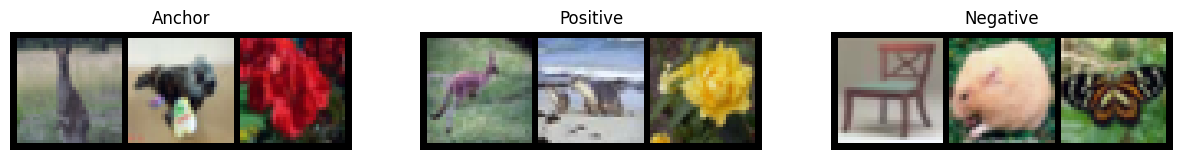

In [20]:
'''
train_loader
test_loader
test_loader_binary
support_loader
query_loader
'''

anchor, positive, negative = next(iter(train_loader))

plt.figure(figsize=(15, 8))

# Plot Anchor
plt.subplot(1, 3, 1)
plt.axis("off")
plt.title("Anchor")
plt.imshow(np.transpose(vutils.make_grid(anchor[:3], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Plot Positive
plt.subplot(1, 3, 2)
plt.axis("off")
plt.title("Positive")
plt.imshow(np.transpose(vutils.make_grid(positive[:3], padding=2, normalize=True).cpu(), (1, 2, 0)))

# Plot Negative
plt.subplot(1, 3, 3)
plt.axis("off")
plt.title("Negative")
plt.imshow(np.transpose(vutils.make_grid(negative[:3], padding=2, normalize=True).cpu(), (1, 2, 0)))

plt.show()

**Let's Train:**

In [22]:
for epoch in range(n_epoch, args.epochs + 1):
    #TRAIN
    train(args, model, device, train_loader, optimizer, epoch)

    if epoch % 25 == 0:
        #TEST
        test(model, device, test_loader)
        binary_test(model, device, test_loader_binary)
        if(K_WAY > 0):
            few_shot_test(model, device, support_loader, query_loader)

        #saving a checkpoint every 25 epochs
        if args.save_model:
            path = PATH + f"siamese_network_{epoch}.pth"
            path_fast_load = PATH + f"siamese_network.pth"

            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch+1,
            }

            torch.save(checkpoint, path)
            torch.save(checkpoint, path_fast_load) #for fast load

            print("- Checkpoint saved successfully")

Train Epoch: 1 [0/50000 (0%)]	Loss: 0.291958
Train Epoch: 1 [1280/50000 (3%)]	Loss: 0.250231
Train Epoch: 1 [2560/50000 (5%)]	Loss: 0.267637
Train Epoch: 1 [3840/50000 (8%)]	Loss: 0.298239


KeyboardInterrupt: 